# Feature Engineering for Machine Learning

## 1. Introduction to Feature Engineering

Feature engineering is a crucial step in the machine learning pipeline that can significantly impact model performance. It involves:

- **Transforming raw data** into a format suitable for ML algorithms
- **Creating new features** that better represent the underlying patterns
- **Selecting relevant features** to improve model performance
- **Reducing dimensionality** to avoid the curse of dimensionality

Good feature engineering requires both domain knowledge and technical skills. In this tutorial, we'll cover practical techniques that can be applied to various types of data.

## 2. Setting Up the Environment
Let's start by importing the necessary libraries for our feature engineering tasks.

In [1]:
#!pip install shap

In [2]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for feature engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_regression, RFE, SelectFromModel
from sklearn.decomposition import PCA

# For modeling
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# For Feature Importance
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import shap

# For pipeline creation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Configure visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")

# Set random seed for reproducibility
np.random.seed(42)

## 3. Loading Example Datasets

We'll use the Titanic dataset from seaborn as our primary example, as it contains various data types including numeric, categorical, and missing values.

In [3]:
# Load the Titanic dataset
titanic = pd.read_csv('titanic.csv')

titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 4. Handling Missing Values

Missing values can significantly impact model performance. Let's explore different strategies for handling them.

Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


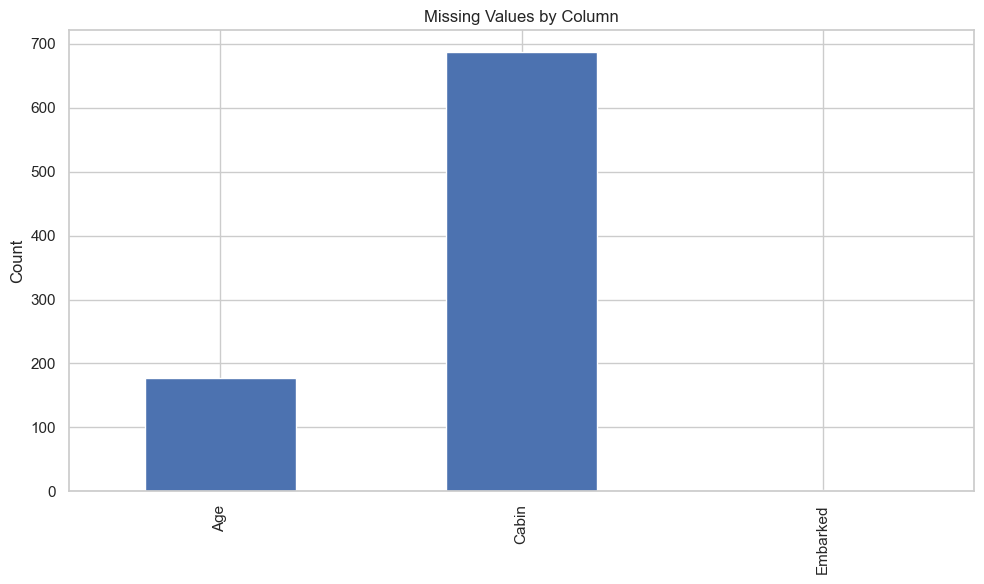

In [4]:
# Check for missing values
missing_values = titanic.isnull().sum()
print(f"Missing values per column:\n{missing_values}")

# Visualize missing values
plt.figure(figsize=(10, 6))
missing_values[missing_values > 0].plot(kind='bar')
plt.title('Missing Values by Column')
plt.ylabel('Count')
plt.tight_layout()

In [5]:
# Create a copy of the dataset to work with
df = titanic.copy()

# 1. Simple imputation - Fill numeric missing values with mean
imputer_mean = SimpleImputer(strategy='mean')
df['age_mean_imputed'] = imputer_mean.fit_transform(df[['Age']])

# 2. Fill numeric missing values with median (better for skewed data)
imputer_median = SimpleImputer(strategy='median')
df['age_median_imputed'] = imputer_median.fit_transform(df[['Age']])

# 3. Fill missing values with mode (common for categorical data)
imputer_mode = SimpleImputer(strategy='most_frequent')
df[['embarked_mode_imputed']] = imputer_mode.fit_transform(df[['Embarked']])

# 4. KNN imputation (uses k-nearest neighbors to impute missing values)
# First, create a subset with only numeric columns for KNN
numeric_cols = ['Age', 'Fare', 'Pclass', 'Survived']
df_numeric = df[numeric_cols].copy()

# Apply KNN imputation
imputer_knn = KNNImputer(n_neighbors=5)
df_numeric_imputed = pd.DataFrame(
    imputer_knn.fit_transform(df_numeric),
    columns=df_numeric.columns
)
df['age_knn_imputed'] = df_numeric_imputed['Age']

# 5. Custom imputation based on domain knowledge
# For example, impute age based on title (Mr, Mrs, Miss, etc.)
# Extract title from name
df['title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)

# Map titles to more common ones
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Dr',
    'Rev': 'Rev',
    'Mlle': 'Miss',
    'Major': 'Mr',
    'Col': 'Mr',
    'Sir': 'Mr',
    'Don': 'Mr',
    'Mme': 'Mrs',
    'Jonkheer': 'Mr',
    'Lady': 'Mrs',
    'Capt': 'Mr',
    'Countess': 'Mrs',
    'Ms': 'Miss',
    'Dona': 'Mrs'
}
df['title'] = df['title'].map(title_mapping)

# Calculate mean age by title
title_age_mean = df.groupby('title')['Age'].mean()

# Function to impute age based on title
def impute_age(row):
    if pd.isnull(row['Age']):
        return title_age_mean[row['title']]
    else:
        return row['Age']

df['age_title_imputed'] = df.apply(impute_age, axis=1)

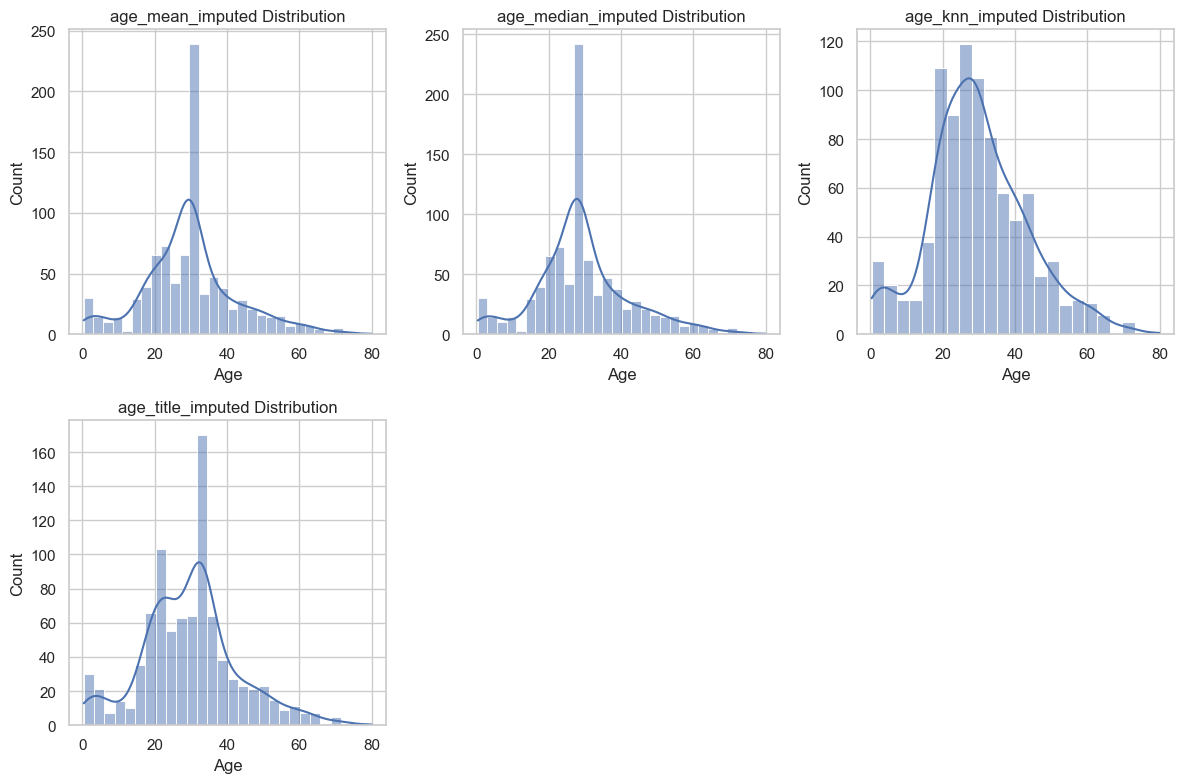

In [6]:
# Compare different imputation methods
age_cols = [col for col in df.columns if 'age' in col]
df_age = df[age_cols]

# Visualize distributions after imputation
plt.figure(figsize=(12, 8))
for i, col in enumerate(age_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(df_age[col].dropna(), kde=True)
    plt.title(f'{col} Distribution')
    plt.xlabel('Age')
plt.tight_layout()

### Advanced Missing Value Handling: Create Missing Value Indicator

Sometimes, the fact that a value is missing can itself be informative. We can create binary indicators for missingness.

Text(0, 0.5, 'Survival Rate')

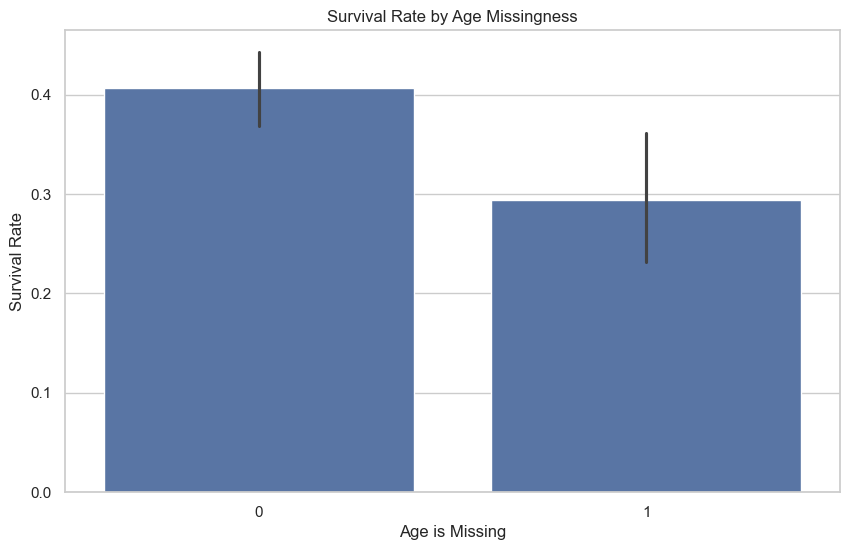

In [7]:
# Create missing indicators
df['age_is_missing'] = df['Age'].isnull().astype(int)
df['cabin_is_missing'] = df['Cabin'].isnull().astype(int)
df['embarked_is_missing'] = df['Embarked'].isnull().astype(int)

# Check if missingness correlates with survival
plt.figure(figsize=(10, 6))
sns.barplot(x='age_is_missing', y='Survived', data=df)
plt.title('Survival Rate by Age Missingness')
plt.xlabel('Age is Missing')
plt.ylabel('Survival Rate')

## 5. Numeric Feature Engineering

Numeric features often require scaling, transformation, binning, and creating interaction terms to improve model performance.

In [8]:
# Use imputed dataset for further processing
df_clean = df.copy()
df_clean['Age'] = df['age_title_imputed']  # Use our best imputation strategy
df_clean = df_clean.drop(columns=[col for col in df.columns if 'imputed' in col])

# 1. Scaling features
numeric_features = ['Age', 'Fare']

# Standard scaling (zero mean, unit variance)
scaler_standard = StandardScaler()
df_clean[['age_scaled', 'fare_scaled']] = scaler_standard.fit_transform(df_clean[numeric_features])

# Min-Max scaling (scale to range [0,1])
scaler_minmax = MinMaxScaler()
df_clean[['age_minmax', 'fare_minmax']] = scaler_minmax.fit_transform(df_clean[numeric_features])

# Robust scaling (scale using quantiles, robust to outliers)
scaler_robust = RobustScaler()
df_clean[['age_robust', 'fare_robust']] = scaler_robust.fit_transform(df_clean[numeric_features])

# 2. Log transformation (useful for skewed data)
# Add a small constant to avoid log(0)
df_clean['fare_log'] = np.log1p(df_clean['Fare'])

# 3. Binning (discretization)
# Bin age into categories
df_clean['age_bins'] = pd.cut(df_clean['Age'], 
                             bins=[0, 12, 18, 35, 60, 100], 
                             labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Senior'])

# Bin fare into quantile-based bins
df_clean['fare_bins'] = pd.qcut(df_clean['Fare'], 
                               q=4, 
                               labels=['Low', 'Medium-Low', 'Medium-High', 'High'])

# 4. Polynomial features (interactions)
df_clean['age_squared'] = df_clean['Age'] ** 2
df_clean['fare_squared'] = df_clean['Fare'] ** 2
df_clean['age_fare_interaction'] = df_clean['Age'] * df_clean['Fare']

# 5. Ratios and differences
# For example, fare per person in the group
df_clean['fare_per_person'] = df_clean['Fare'] / (df_clean['SibSp'] + df_clean['Parch'] + 1)

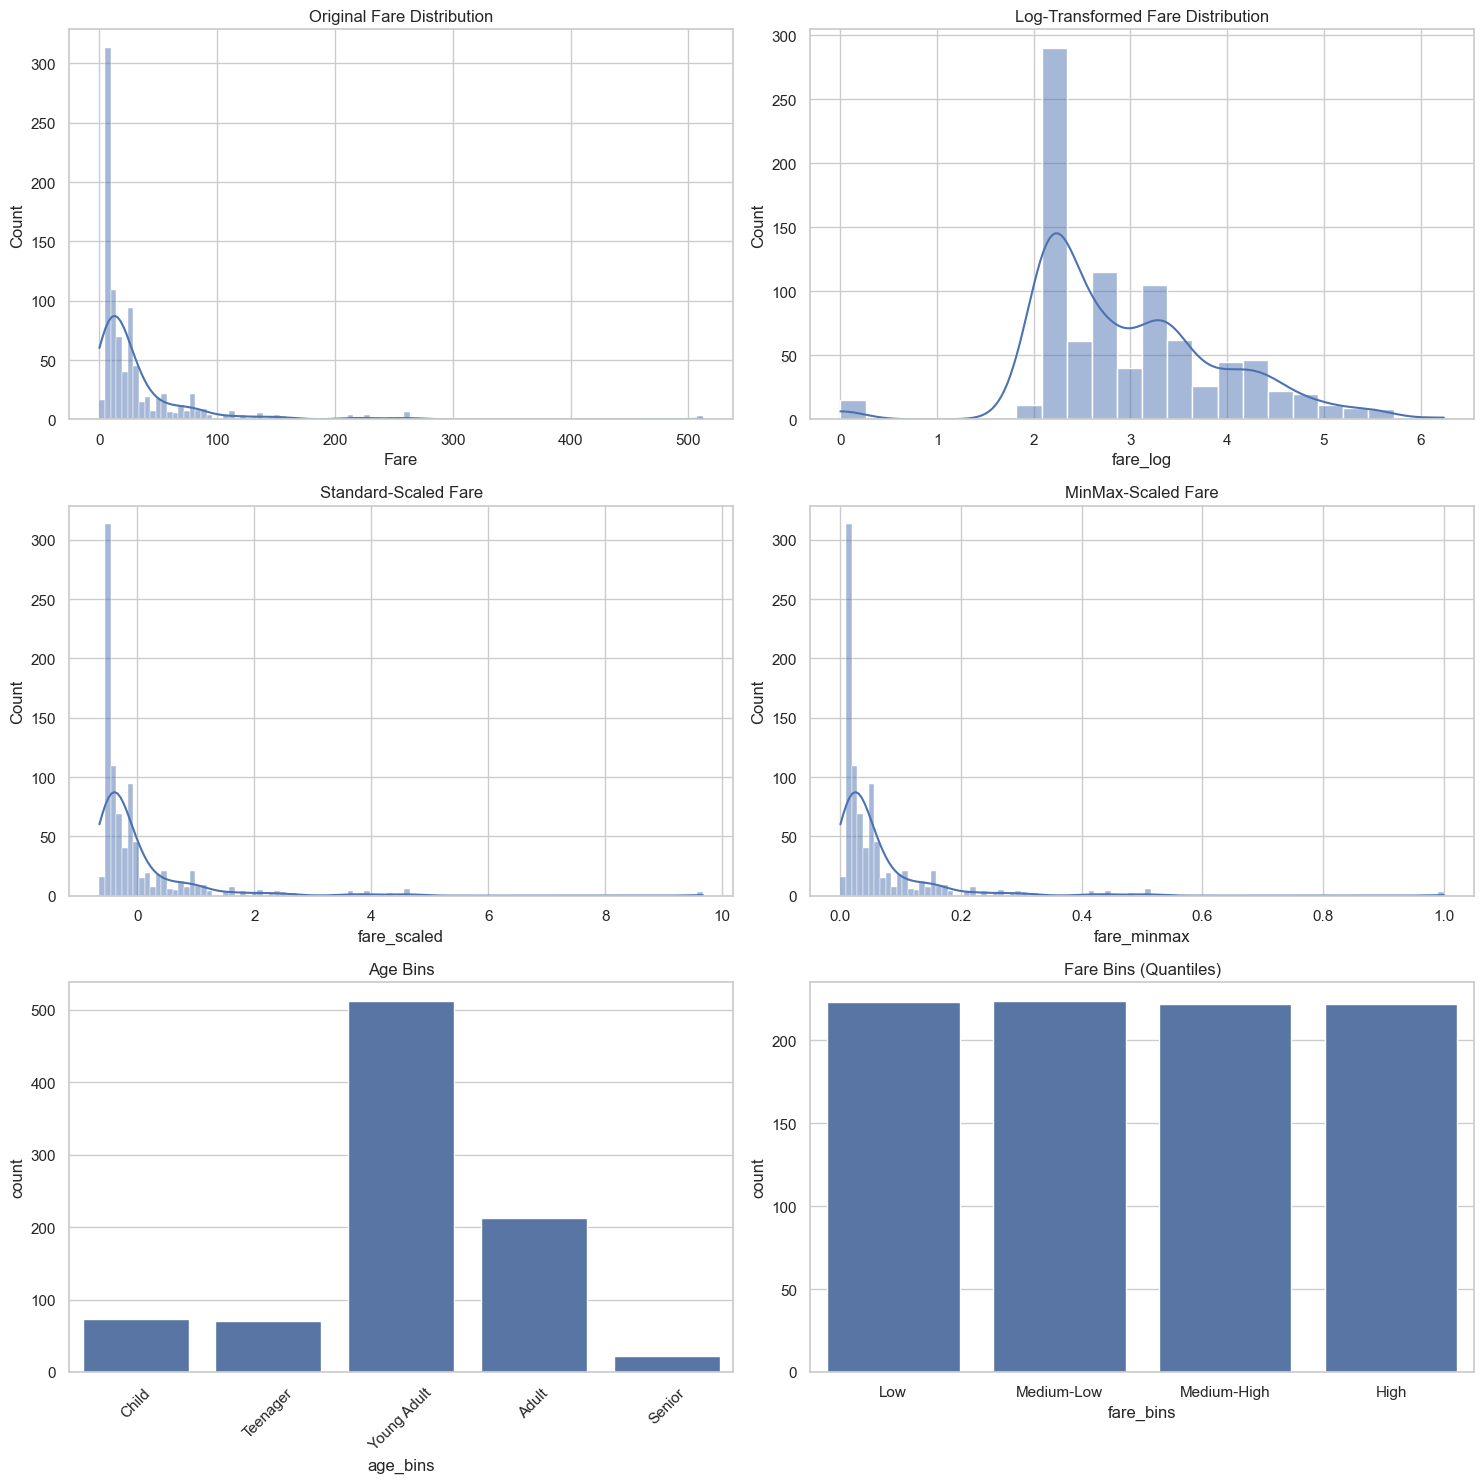

In [9]:
# Visualize the transformations
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Original distributions
sns.histplot(df_clean['Fare'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Original Fare Distribution')

# Log transformation
sns.histplot(df_clean['fare_log'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Log-Transformed Fare Distribution')

# Different scaling methods
sns.histplot(df_clean['fare_scaled'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Standard-Scaled Fare')

sns.histplot(df_clean['fare_minmax'], kde=True, ax=axes[1, 1])
axes[1, 1].set_title('MinMax-Scaled Fare')

# Binning visualization
sns.countplot(x='age_bins', data=df_clean, ax=axes[2, 0])
axes[2, 0].set_title('Age Bins')
axes[2, 0].tick_params(axis='x', rotation=45)

sns.countplot(x='fare_bins', data=df_clean, ax=axes[2, 1])
axes[2, 1].set_title('Fare Bins (Quantiles)')

plt.tight_layout()

### Analyzing the relationship between engineered features and target

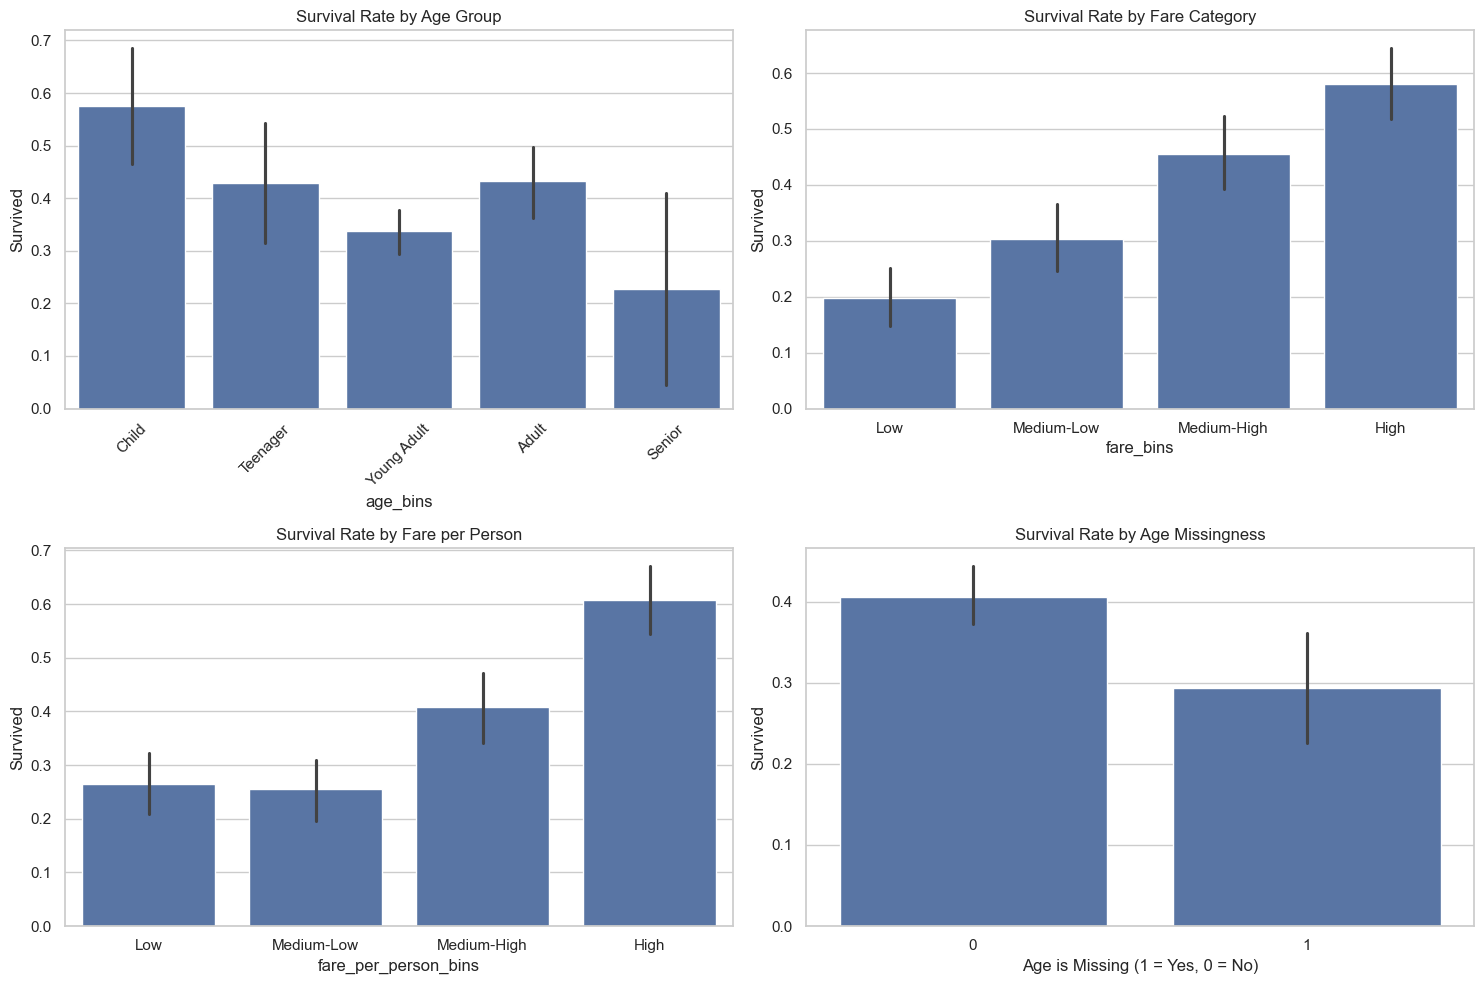

In [10]:
# Create a figure to visualize relationships with target
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age bins vs. survival
sns.barplot(x='age_bins', y='Survived', data=df_clean, ax=axes[0, 0])
axes[0, 0].set_title('Survival Rate by Age Group')
axes[0, 0].tick_params(axis='x', rotation=45)

# Fare bins vs. survival
sns.barplot(x='fare_bins', y='Survived', data=df_clean, ax=axes[0, 1])
axes[0, 1].set_title('Survival Rate by Fare Category')

# Fare per person vs. survival
# Group fare_per_person into bins for visualization
df_clean['fare_per_person_bins'] = pd.qcut(df_clean['fare_per_person'], 
                                          q=4, 
                                          labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
sns.barplot(x='fare_per_person_bins', y='Survived', data=df_clean, ax=axes[1, 0])
axes[1, 0].set_title('Survival Rate by Fare per Person')

# Age is missing vs. survival (from previous section)
sns.barplot(x='age_is_missing', y='Survived', data=df_clean, ax=axes[1, 1])
axes[1, 1].set_title('Survival Rate by Age Missingness')
axes[1, 1].set_xlabel('Age is Missing (1 = Yes, 0 = No)')

plt.tight_layout()

## 6. Categorical Feature Engineering
Categorical features require special handling for machine learning models to interpret them correctly.

In [11]:
# Working with categorical variables
df_cat = df_clean.copy()

# 1. Label Encoding (for ordinal categories)
# Example: 'pclass' has a natural ordering (1 > 2 > 3)
label_encoder = LabelEncoder()
df_cat['pclass_encoded'] = label_encoder.fit_transform(df_cat['Pclass'])

# 2. One-Hot Encoding (for nominal categories)
# Example: sex, embarked
cat_cols = ['Sex', 'Embarked']
df_cat = pd.get_dummies(df_cat, columns=cat_cols, prefix=cat_cols, drop_first=True)

# 3. Binary encoding (for high-cardinality features)
# Example: title (extracted earlier)
df_cat = pd.get_dummies(df_cat, columns=['title'], prefix='title')

# 4. Frequency encoding (replace category with its frequency)
cabin_freq = df_cat['Cabin'].fillna('Missing').value_counts(normalize=True)
df_cat['cabin_freq'] = df_cat['Cabin'].fillna('Missing').map(cabin_freq)

# 5. Feature crossing (combining categorical features)
# Cross sex and pclass
df_cat['sex_pclass'] = df_cat['Sex_male'].astype(str) + '_' + df_cat['Pclass'].astype(str)
df_cat = pd.get_dummies(df_cat, columns=['sex_pclass'], prefix='sex_pclass')

C:\Users\marti\AppData\Local\Temp\ipykernel_5808\350985023.py:5: FutureWarning: The provided callable <function mean at 0x0000028E5EDA7B50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  result = plot_df.groupby(["sex_pclass"])['Survived'].aggregate(np.mean).reset_index().sort_values('sex_pclass')


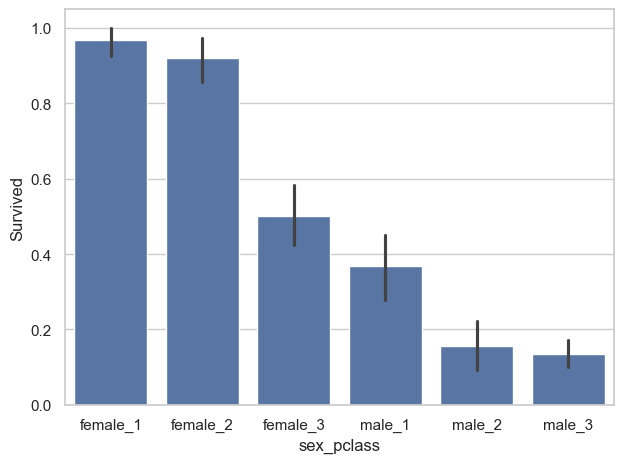

In [12]:
# Feature crossing effect
# Create temporary dataframe for plotting
plot_df = titanic.copy()
plot_df['sex_pclass'] = plot_df['Sex'] + '_' + plot_df['Pclass'].astype(str)
result = plot_df.groupby(["sex_pclass"])['Survived'].aggregate(np.mean).reset_index().sort_values('sex_pclass')
sns.barplot(x='sex_pclass', y='Survived', data=plot_df, order=result['sex_pclass'])

plt.tight_layout()

## 7. Date and Time Features

Date and time features can provide valuable information when extracted properly. Let's create a simple example dataset with date information.

In [13]:
# Create a sample dataset with date features
date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
np.random.seed(42)
sales = np.random.normal(loc=1000, scale=200, size=len(date_range))
sales = np.abs(sales)  # Ensure positive sales

# Add seasonality pattern
day_of_year = np.array([d.dayofyear for d in date_range])
seasonal_component = 200 * np.sin(2 * np.pi * day_of_year / 365)
sales = sales + seasonal_component

# Add weekend effect
is_weekend = np.array([1 if d.dayofweek >= 5 else 0 for d in date_range])
weekend_boost = is_weekend * 100
sales = sales + weekend_boost

# Create dataframe
sales_df = pd.DataFrame({
    'date': date_range,
    'sales': sales
})

sales_df.head()

,date,sales
0,2022-01-01,1202.785502
1,2022-01-02,1079.231462
2,2022-01-03,1139.861641
3,2022-01-04,1318.366457
4,2022-01-05,970.362285


In [14]:
# Extract date features
sales_df['year'] = sales_df['date'].dt.year
sales_df['month'] = sales_df['date'].dt.month
sales_df['day'] = sales_df['date'].dt.day
sales_df['dayofweek'] = sales_df['date'].dt.dayofweek
sales_df['is_weekend'] = sales_df['dayofweek'].isin([5, 6]).astype(int)
sales_df['quarter'] = sales_df['date'].dt.quarter
sales_df['dayofyear'] = sales_df['date'].dt.dayofyear
sales_df['weekofyear'] = sales_df['date'].dt.isocalendar().week

# Create month-end and month-start indicators
sales_df['is_month_end'] = sales_df['date'].dt.is_month_end.astype(int)
sales_df['is_month_start'] = sales_df['date'].dt.is_month_start.astype(int)

# Create cyclical features for month, day of week, etc.
# This preserves the cyclical nature (e.g., December is close to January)
sales_df['month_sin'] = np.sin(2 * np.pi * sales_df['month'] / 12)
sales_df['month_cos'] = np.cos(2 * np.pi * sales_df['month'] / 12)
sales_df['dayofweek_sin'] = np.sin(2 * np.pi * sales_df['dayofweek'] / 7)
sales_df['dayofweek_cos'] = np.cos(2 * np.pi * sales_df['dayofweek'] / 7)

# Calculate lag features (previous day, week, month)
sales_df['sales_lag1'] = sales_df['sales'].shift(1)
sales_df['sales_lag7'] = sales_df['sales'].shift(7)
sales_df['sales_lag30'] = sales_df['sales'].shift(30)

# Calculate rolling statistics
sales_df['sales_rolling_mean7'] = sales_df['sales'].rolling(window=7).mean()
sales_df['sales_rolling_std7'] = sales_df['sales'].rolling(window=7).std()

# Drop rows with NaN from lag features
sales_df = sales_df.dropna()

Text(0.5, 1.0, 'Day of Week (0=Monday, 6=Sunday)')

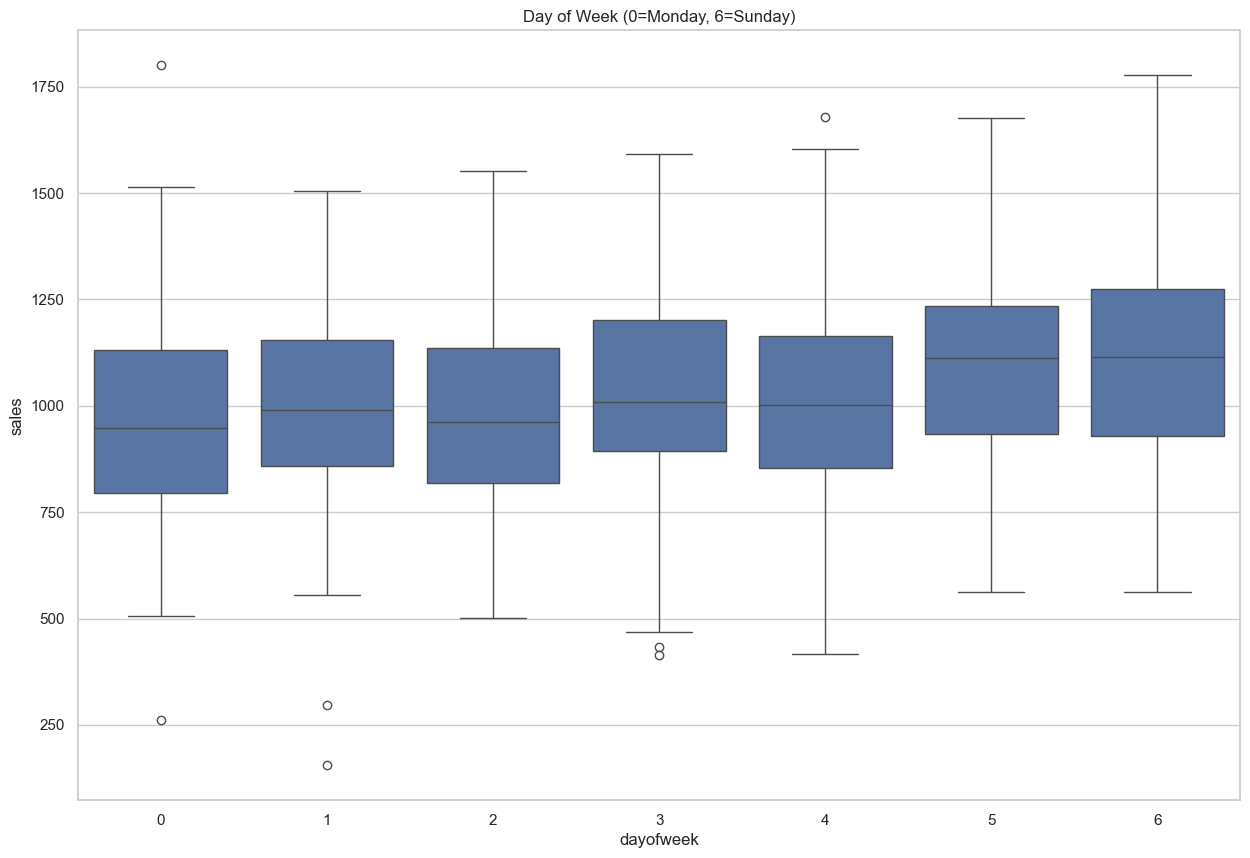

In [15]:
# Visualize the relationship between date features and sales
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

# Sales by day of week
sns.boxplot(x='dayofweek', y='sales', data=sales_df)
axes.set_title('Sales by Day of Week')
axes.set_title('Day of Week (0=Monday, 6=Sunday)')

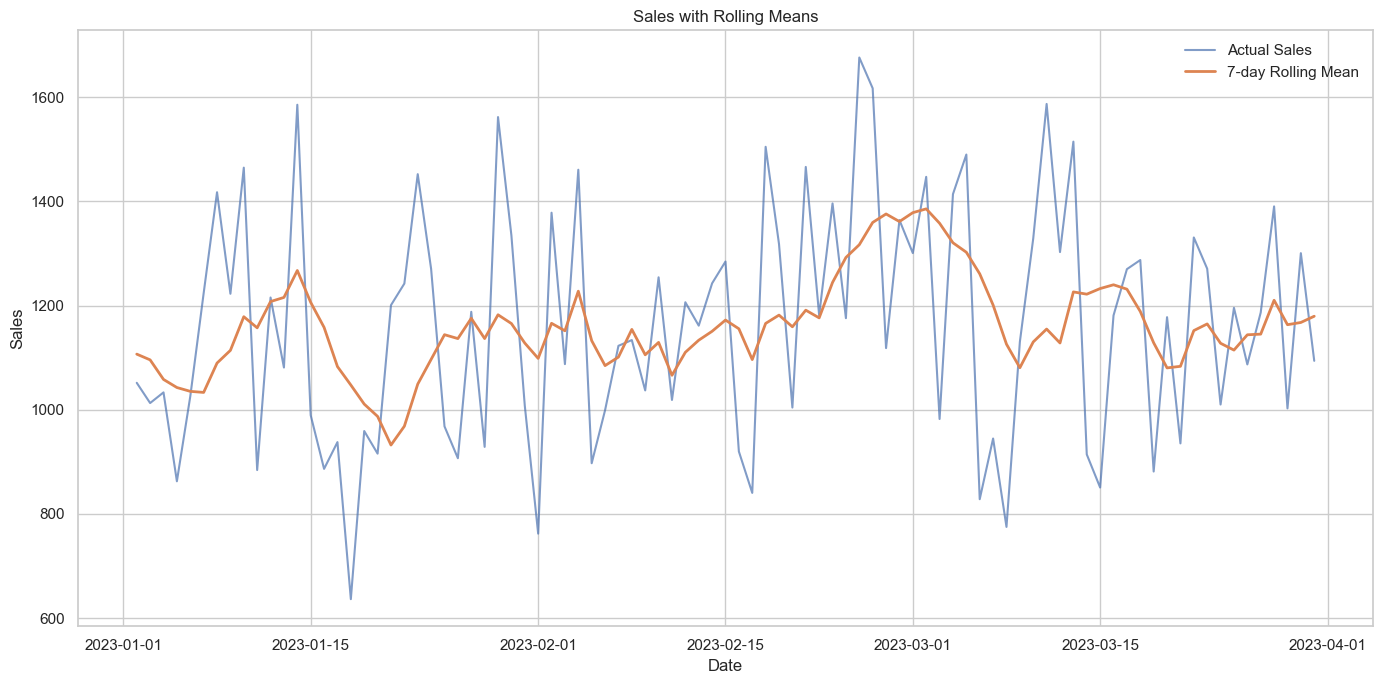

In [16]:
# Visualize original sales and rolling means
plt.figure(figsize=(14, 7))

# Subset to a shorter period for better visualization
plot_data = sales_df.loc[(sales_df.date>'2023-01-01') & (sales_df.date<='2023-03-31')]

plt.plot(plot_data['date'], plot_data['sales'], label='Actual Sales', alpha=0.7)
plt.plot(plot_data['date'], plot_data['sales_rolling_mean7'], label='7-day Rolling Mean', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales with Rolling Means')
plt.legend()
plt.grid(True)
plt.tight_layout()

### 7.1 Date Difference Features

Sometimes it's valuable to calculate the time elapsed since specific events:

In [17]:
# Create sample customer transaction data
np.random.seed(42)
customer_ids = range(1, 101)
transaction_data = []

for customer_id in customer_ids:
    # Random number of transactions per customer
    n_transactions = np.random.randint(1, 10)
    
    # Generate transaction dates
    start_date = pd.Timestamp('2022-01-01') + pd.Timedelta(days=np.random.randint(0, 90))
    for i in range(n_transactions):
        # Add a random gap between transactions
        if i > 0:
            start_date += pd.Timedelta(days=np.random.randint(1, 60))
        
        # Skip if beyond our timeframe
        if start_date > pd.Timestamp('2022-12-31'):
            continue
            
        # Add transaction
        amount = np.random.lognormal(4, 0.5)  # Random transaction amount
        transaction_data.append({
            'customer_id': customer_id,
            'transaction_date': start_date,
            'amount': amount
        })

# Create DataFrame
df_transactions = pd.DataFrame(transaction_data)
df_transactions = df_transactions.sort_values(['customer_id', 'transaction_date']).reset_index(drop=True)

# Display sample
df_transactions.head()

,customer_id,transaction_date,amount
0,1,2022-02-21,31.313833
1,1,2022-03-12,64.036363
2,1,2022-04-04,120.254028
3,1,2022-04-26,80.135373
4,1,2022-06-18,40.835873


Now let's create time-related features based on transaction history:

In [18]:
# Reference date (e.g., for predicting churn on this date)
reference_date = pd.Timestamp('2023-01-01')

# Group by customer and create aggregations
customer_features = df_transactions.groupby('customer_id').agg(
    first_transaction_date=('transaction_date', 'min'),
    last_transaction_date=('transaction_date', 'max'),
    transaction_count=('transaction_date', 'count'),
    total_spent=('amount', 'sum'),
    avg_transaction_amount=('amount', 'mean')
).reset_index()

# Create time-based features
customer_features['days_since_first'] = (reference_date - customer_features['first_transaction_date']).dt.days
customer_features['days_since_last'] = (reference_date - customer_features['last_transaction_date']).dt.days
customer_features['account_age_days'] = (customer_features['last_transaction_date'] - 
                                         customer_features['first_transaction_date']).dt.days

# Calculate transaction frequency
# Add 1 to avoid division by zero for customers with just one transaction
customer_features['avg_days_between_transactions'] = customer_features['account_age_days'] / \
                                                    (customer_features['transaction_count'] - 1 + 1e-10)

# Flag potentially churned customers (no transaction in 90 days)
customer_features['potential_churn'] = customer_features['days_since_last'] > 90

# Calculate time-based spending metrics
customer_features['spend_per_day'] = customer_features['total_spent'] / \
                                     (customer_features['account_age_days'] + 1)  # Add 1 to avoid division by zero

# Display the results
customer_features.head()

,customer_id,first_transaction_date,last_transaction_date,transaction_count,total_spent,avg_transaction_amount,days_since_first,days_since_last,account_age_days,avg_days_between_transactions,potential_churn,spend_per_day
0,1,2022-02-21,2022-08-11,7,440.184451,62.883493,314,143,171,28.500,True,2.559212
1,2,2022-02-18,2022-10-21,9,575.629664,63.958852,317,72,245,30.625,False,2.339958
2,3,2022-01-04,2022-03-03,2,133.378971,66.689486,362,304,58,58.000,True,2.260661
3,4,2022-03-31,2022-09-14,9,430.867346,47.874150,276,109,167,20.875,True,2.564687
4,5,2022-01-14,2022-04-20,4,133.466424,33.366606,352,256,96,32.000,True,1.375943


Let's visualize the relationship between days since last transaction and spending behavior:

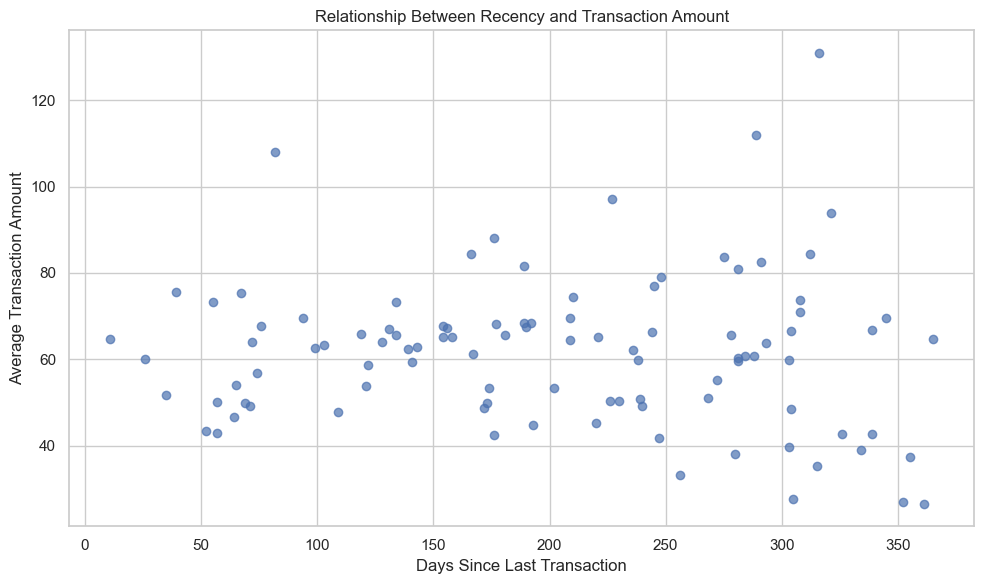

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(customer_features['days_since_last'], 
            customer_features['avg_transaction_amount'],
            alpha=0.7)
plt.xlabel('Days Since Last Transaction')
plt.ylabel('Average Transaction Amount')
plt.title('Relationship Between Recency and Transaction Amount')
plt.grid(True)
plt.tight_layout()

## 8. Feature Selection

Feature selection is the process of identifying and selecting the most relevant features for your model. This helps improve model performance, reduce training time, and prevent overfitting.

In this section, we'll explore various feature selection techniques:

In [20]:
# For demonstration purposes, let's use a placeholder dataset
# This would normally be your processed dataframe from previous sections

np.random.seed(20)

X = pd.DataFrame(np.random.rand(100, 15), columns=[f'feature_{i}' for i in range(15)])
y = pd.Series(np.random.rand(100),name='y')

### 9.1 Filter Methods

Filter methods use statistical techniques to evaluate the relationship between each feature and the target variable.

Top 5 features based on F-statistic:
       Feature     Score
3    feature_3  4.055285
12  feature_12  3.598226
13  feature_13  2.274767
9    feature_9  0.672188
7    feature_7  0.486380


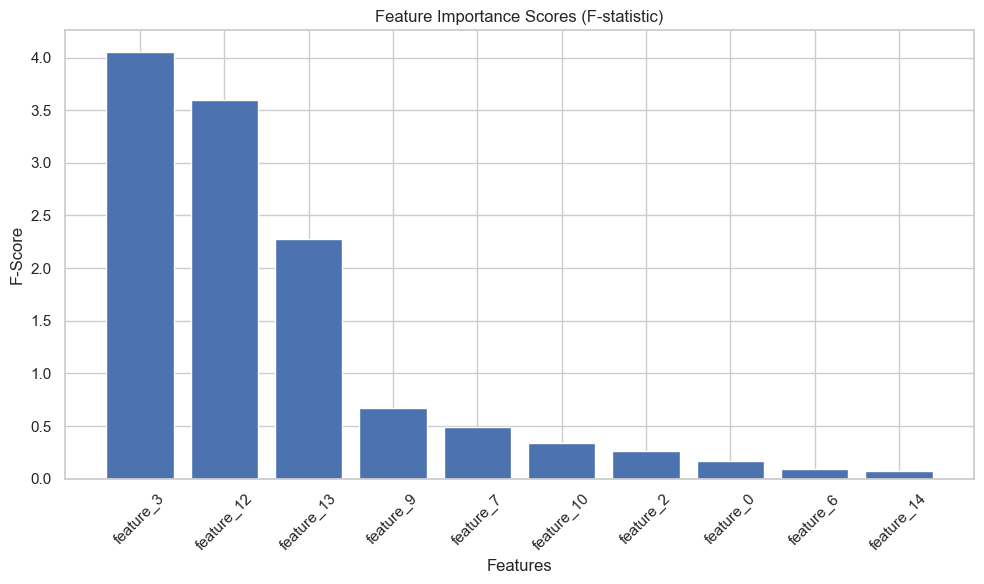

In [21]:
# 2. Univariate Feature Selection (using F-statistic)
selector = SelectKBest(score_func=f_regression, k=5)  # Select top 5 features
X_uni_selected = selector.fit_transform(X, y)
selected_features_uni = X.columns[selector.get_support()]

# Display results
scores = pd.DataFrame({
    'Feature': X.columns,
    'Score': selector.scores_
}).sort_values('Score', ascending=False)

print("Top 5 features based on F-statistic:")
print(scores.head(5))

# Visualization
plt.figure(figsize=(10, 6))
plt.bar(scores['Feature'].head(10), scores['Score'].head(10))
plt.title('Feature Importance Scores (F-statistic)')
plt.xlabel('Features')
plt.ylabel('F-Score')
plt.xticks(rotation=45)
plt.tight_layout()

### 9.2 Wrapper Methods

Wrapper methods use a model to evaluate feature importance and select features.

In [22]:
# Recursive Feature Elimination (RFE)
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=5)
X_rfe = rfe.fit_transform(X, y)
selected_features_rfe = X.columns[rfe.support_]

print("Features selected by RFE:")
print(selected_features_rfe.tolist())

# Feature ranking (1 means selected)
feature_ranking = pd.DataFrame({
    'Feature': X.columns,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print("\nFeature ranking (1 is highest):\n")
print(feature_ranking)

Features selected by RFE:
['feature_3', 'feature_7', 'feature_12', 'feature_13', 'feature_14']

Feature ranking (1 is highest):

       Feature  Ranking
3    feature_3        1
7    feature_7        1
14  feature_14        1
13  feature_13        1
12  feature_12        1
10  feature_10        2
2    feature_2        3
0    feature_0        4
9    feature_9        5
5    feature_5        6
6    feature_6        7
8    feature_8        8
1    feature_1        9
11  feature_11       10
4    feature_4       11


### 9.3 Embedded Methods

Embedded methods perform feature selection as part of the model training process.

Feature importance based on Lasso coefficients:
       Feature  Coefficient
3    feature_3    -0.043262
12  feature_12    -0.035100
13  feature_13    -0.029342
7    feature_7    -0.011238
10  feature_10     0.009622
2    feature_2     0.009342
14  feature_14     0.008730
0    feature_0    -0.007019
9    feature_9    -0.006242
6    feature_6     0.003662
8    feature_8    -0.000421
5    feature_5     0.000000
4    feature_4    -0.000000
1    feature_1    -0.000000
11  feature_11     0.000000


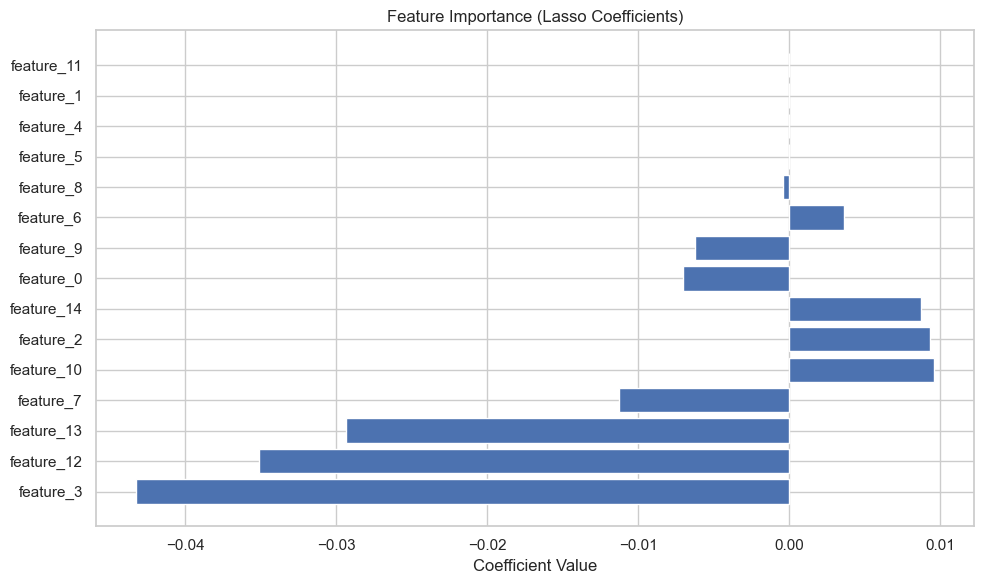

In [23]:
# 1. Lasso Regression (L1 Regularization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y)

# Get coefficients
lasso_coefs = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Feature importance based on Lasso coefficients:")
print(lasso_coefs)

selected_features_lasso = lasso_coefs.loc[np.abs(lasso_coefs.Coefficient)>0.00001,'Feature'].tolist()

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(lasso_coefs['Feature'], lasso_coefs['Coefficient'])
plt.title('Feature Importance (Lasso Coefficients)')
plt.xlabel('Coefficient Value')
plt.tight_layout()

Feature importance based on Random Forest:
       Feature  Importance
12  feature_12    0.109906
3    feature_3    0.107639
4    feature_4    0.077006
10  feature_10    0.076837
2    feature_2    0.072758
14  feature_14    0.068726
13  feature_13    0.064515
9    feature_9    0.060887
1    feature_1    0.059114
5    feature_5    0.058548
7    feature_7    0.055544
8    feature_8    0.053819
0    feature_0    0.050455
11  feature_11    0.045141
6    feature_6    0.039108

Selected features: ['feature_3', 'feature_12']
Number of selected features: 2


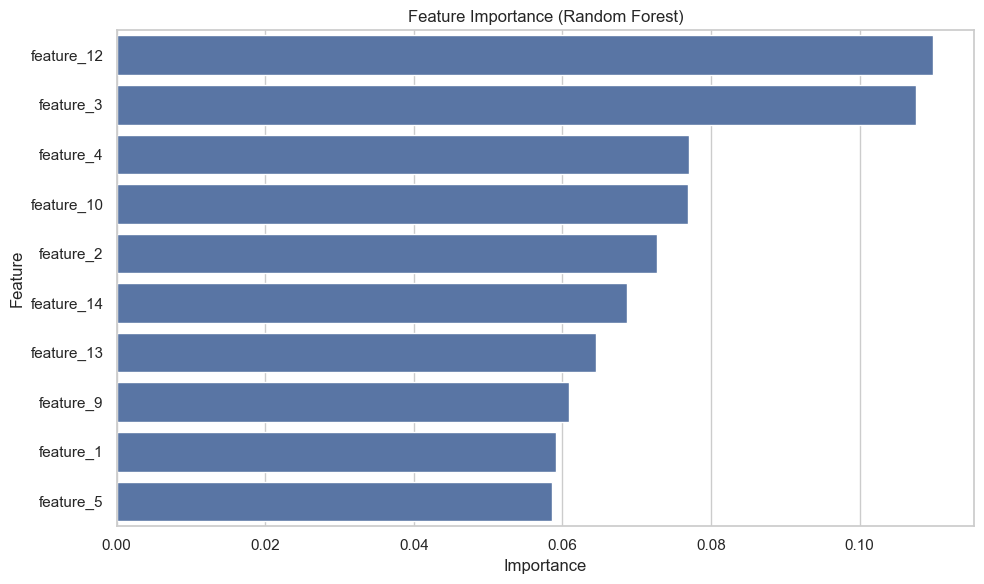

In [24]:
# 2. Feature selection using Random Forest importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature importance based on Random Forest:")
print(rf_importances)

# Select features based on importance threshold
selector = SelectFromModel(rf, threshold=0.1)  # Select features with importance > 0.1
X_rf_selected = selector.fit_transform(X, y)
selected_features_rf = X.columns[selector.get_support()]

print(f"\nSelected features: {selected_features_rf.tolist()}")
print(f"Number of selected features: {len(selected_features_rf)}")

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances.head(10))
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()

### 9.4 Correlation-based Feature Selection


Features to drop due to high correlation: []

Remaining features: ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14']


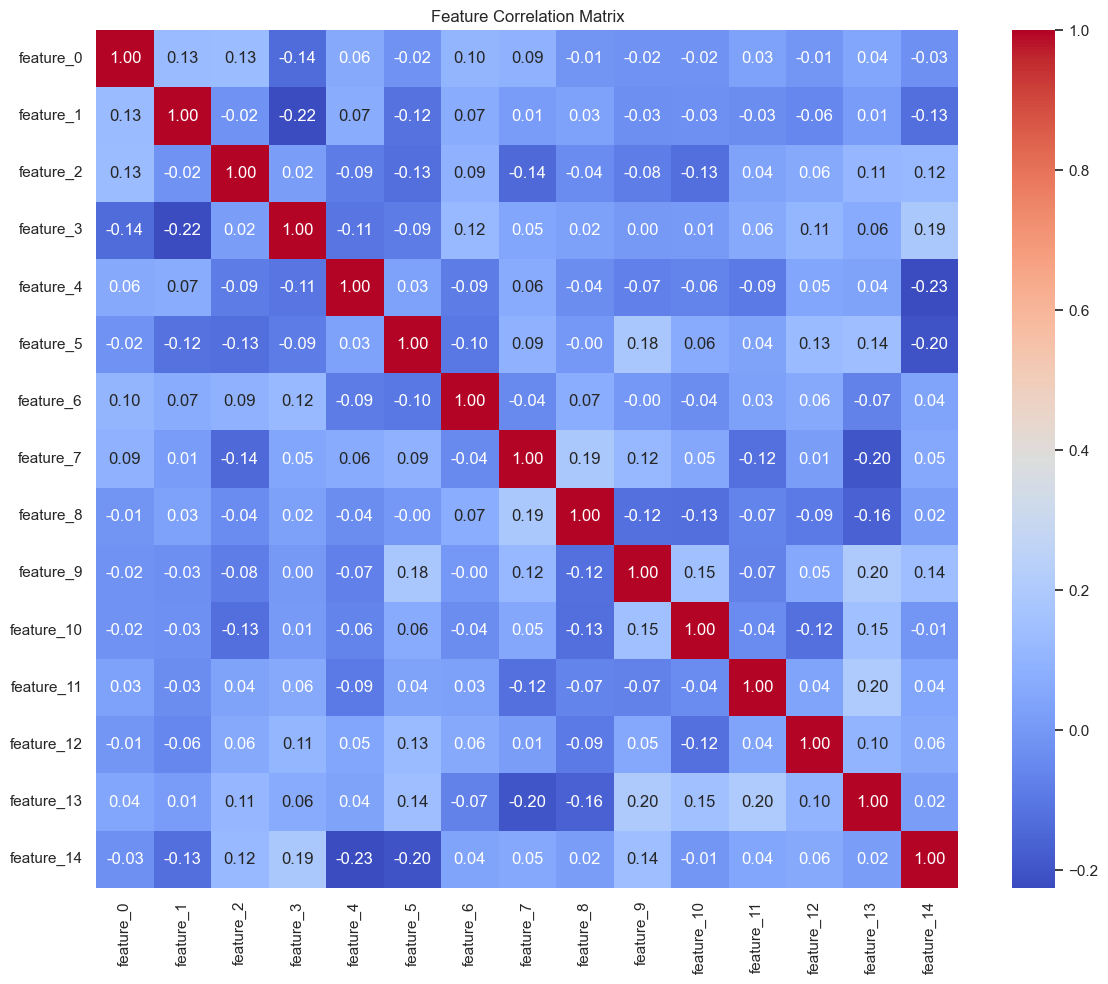

In [25]:
# Correlation matrix
correlation_matrix = X.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()

# Function to find highly correlated features
def identify_collinear_features(correlation_matrix, threshold=0.8):
    features = correlation_matrix.columns
    to_drop = []
    
    for i in range(len(features)):
        for j in range(i+1, len(features)):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                # If two features are highly correlated, keep one and drop the other
                print(f"High correlation between {features[i]} and {features[j]}: {correlation_matrix.iloc[i, j]:.2f}")
                to_drop.append(features[j])
    
    # Remove duplicates
    to_drop = list(set(to_drop))
    print(f"\nFeatures to drop due to high correlation: {to_drop}")
    return to_drop

features_to_drop = identify_collinear_features(correlation_matrix, 0.8)
X_reduced = X.drop(columns=features_to_drop)
print(f"\nRemaining features: {X_reduced.columns.tolist()}")

### 9.5 Comparing Feature Selection Methods

Feature selection method comparison:
            Univariate Selection  RFE  Lasso Regression  Random Forest  Total
feature_3                      1    1                 1              1      4
feature_12                     1    1                 1              1      4
feature_7                      1    1                 1              0      3
feature_13                     1    1                 1              0      3
feature_9                      1    0                 1              0      2
feature_14                     0    1                 1              0      2
feature_2                      0    0                 1              0      1
feature_0                      0    0                 1              0      1
feature_8                      0    0                 1              0      1
feature_10                     0    0                 1              0      1
feature_6                      0    0                 1              0      1
feature_5                  

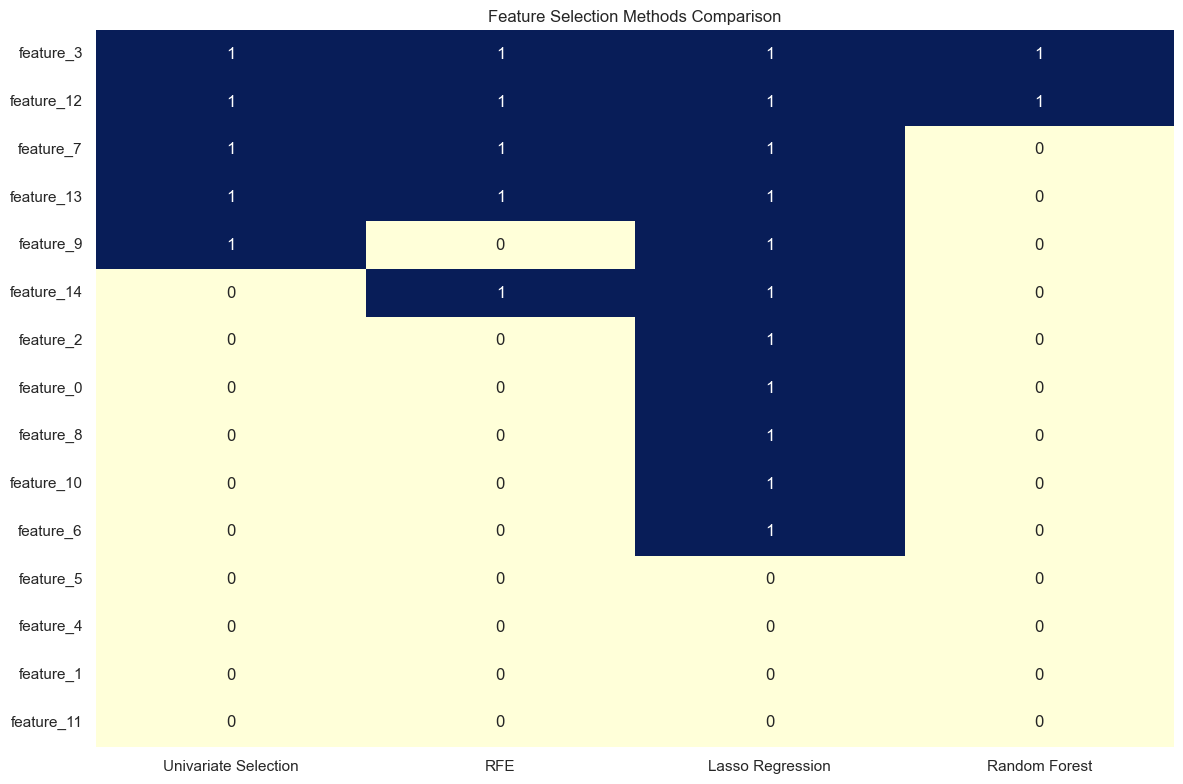

In [26]:
# Compare the results from different feature selection methods
methods = {
    'Univariate Selection': selected_features_uni,
    'RFE': selected_features_rfe,
    'Lasso Regression': selected_features_lasso,
    'Random Forest': selected_features_rf
}

# Create a comparison DataFrame
comparison = pd.DataFrame(index=X.columns)

for method_name, selected in methods.items():
    comparison[method_name] = [1 if feature in selected else 0 for feature in X.columns]

# Add a column for the sum (how many methods selected each feature)
comparison['Total'] = comparison.sum(axis=1)
comparison = comparison.sort_values('Total', ascending=False)

print("Feature selection method comparison:")
print(comparison)

# Visualization
plt.figure(figsize=(12, 8))
sns.heatmap(comparison.iloc[:, :-1], cmap='YlGnBu', annot=True, cbar=False)
plt.title('Feature Selection Methods Comparison')
plt.tight_layout()

In [27]:
# Select the features that were chosen by at least 2 methods
best_features = comparison[comparison['Total'] >= 2].index.tolist()
print(f"Final selected features: {best_features}")
print(f"Number of selected features: {len(best_features)}")

# Create the final feature set
X_final = X[best_features]

Final selected features: ['feature_3', 'feature_12', 'feature_7', 'feature_13', 'feature_9', 'feature_14']
Number of selected features: 6


<a id='feature_importance'></a>
## 10. Feature Importance Analysis

Once we have selected our features, it's crucial to understand their relative importance in predicting the target variable. This helps with model interpretability and further feature refinement.

In [28]:
# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

### 10.1 Model-Based Feature Importance

Random Forest Feature Importances:
      Feature  Importance
1  feature_12    0.219119
2   feature_7    0.186825
3  feature_13    0.171219
0   feature_3    0.158653
5  feature_14    0.138471
4   feature_9    0.125712


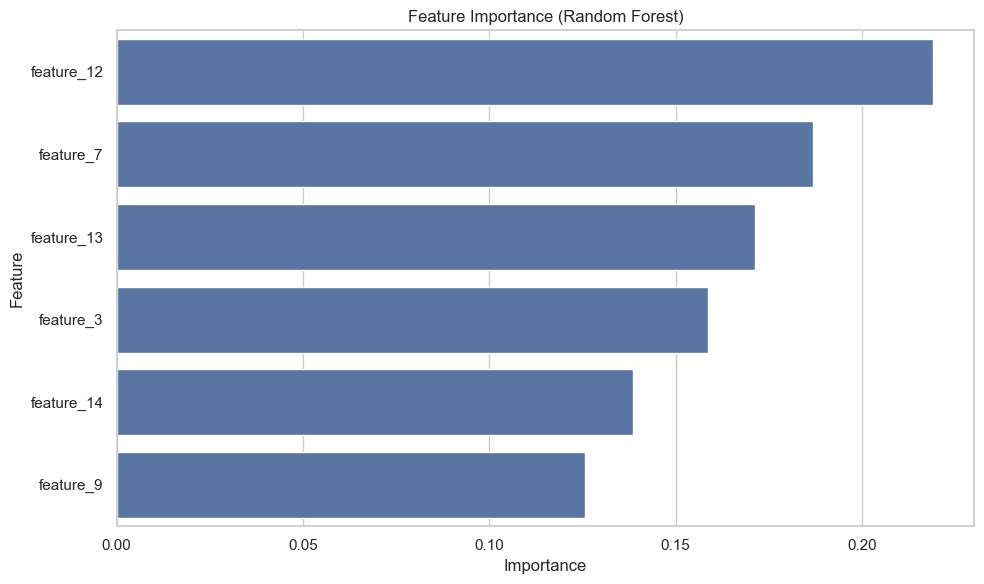

In [29]:
# 1. Random Forest feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importances
rf_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Random Forest Feature Importances:")
print(rf_importances)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=rf_importances)
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()

Gradient Boosting Feature Importances:
      Feature  Importance
3  feature_13    0.209330
1  feature_12    0.197247
5  feature_14    0.172065
0   feature_3    0.158833
4   feature_9    0.136725
2   feature_7    0.125800


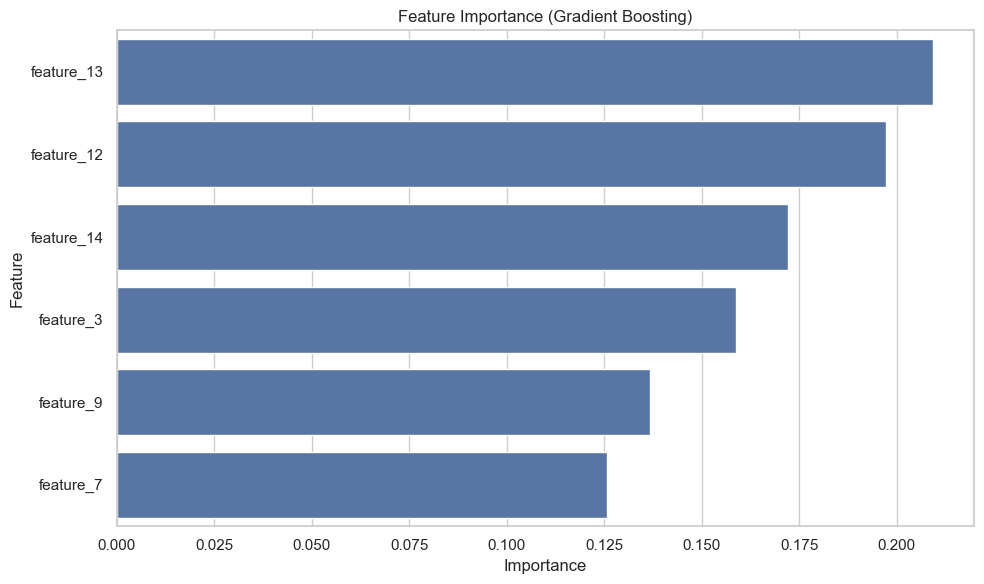

In [30]:
# 2. Gradient Boosting feature importance
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# Get feature importances
gb_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Gradient Boosting Feature Importances:")
print(gb_importances)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=gb_importances)
plt.title('Feature Importance (Gradient Boosting)')
plt.tight_layout()

### 10.3 SHAP Values

SHAP (SHapley Additive exPlanations) values provide detailed insights into feature contributions for individual predictions.

C:\Users\marti\AppData\Local\Temp\ipykernel_5808\1750796527.py:6: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test, plot_type="bar")


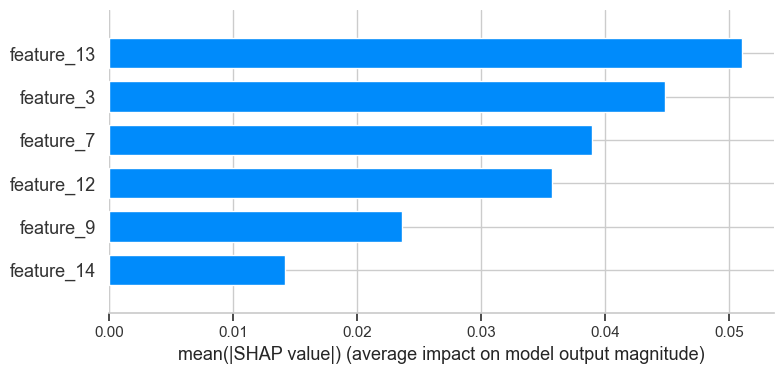

C:\Users\marti\AppData\Local\Temp\ipykernel_5808\1750796527.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


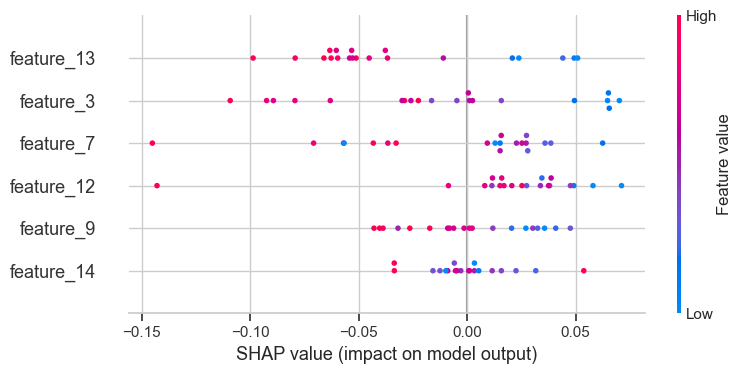

In [31]:
# SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Detailed SHAP plot showing feature impacts
shap.summary_plot(shap_values, X_test)


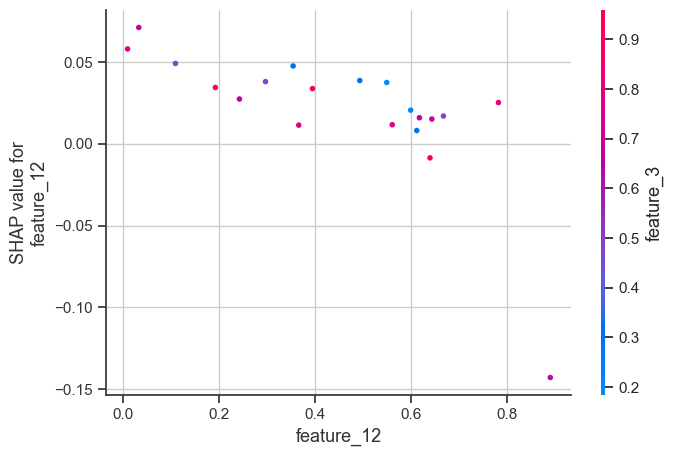

In [32]:
# SHAP dependence plot for the most important feature
most_important_feature = rf_importances['Feature'].iloc[0]
shap.dependence_plot(most_important_feature, shap_values, X_test)


### 10.4 Feature Importance Stability Analysis

It's important to assess how stable feature importance rankings are across different samples of the data.

Feature Importance Stability Metrics:
                mean       std       min       max  coefficient_of_variation
Feature                                                                     
feature_12  0.206610  0.065191  0.108484  0.329236                  0.315529
feature_7   0.202187  0.045984  0.121147  0.266665                  0.227432
feature_13  0.183975  0.076975  0.067705  0.336618                  0.418400
feature_3   0.168467  0.072538  0.054982  0.416671                  0.430579
feature_14  0.126050  0.029414  0.085418  0.179262                  0.233349
feature_9   0.112711  0.030975  0.062812  0.186192                  0.274819


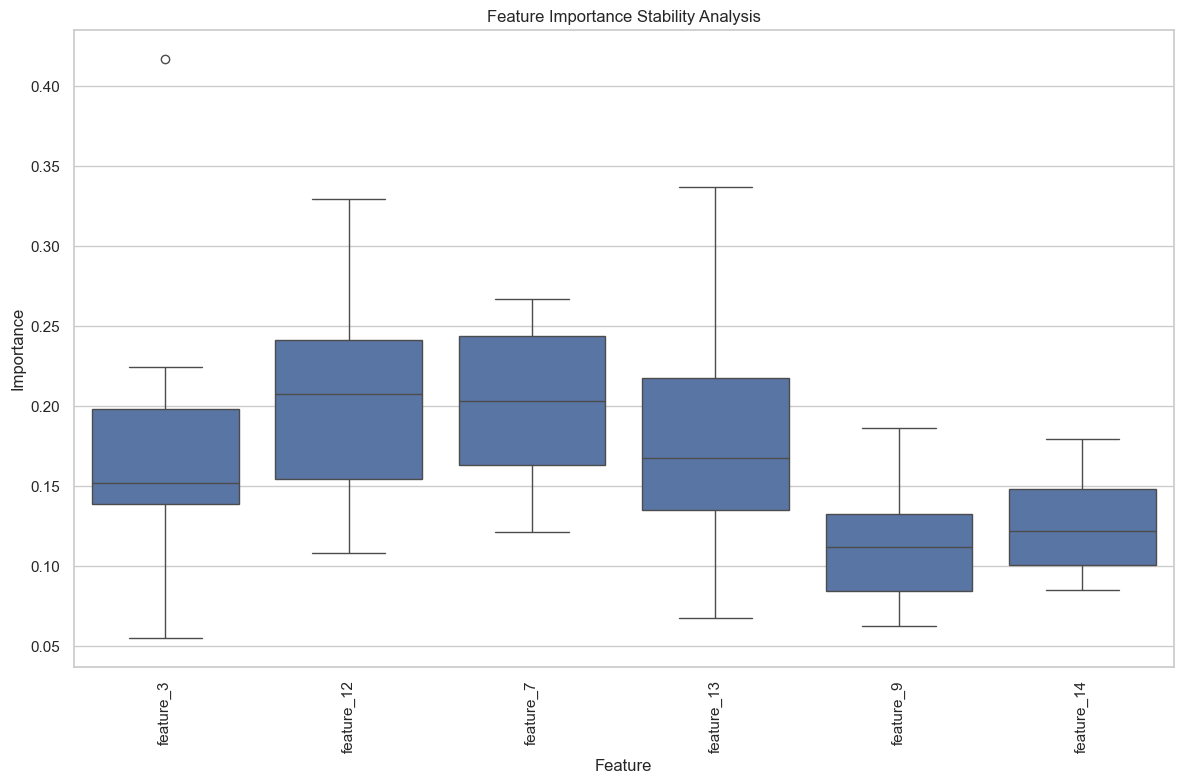

In [33]:
# Stability analysis using bootstrapping
n_iterations = 20
importances = []
np.random.seed(42)

for i in range(n_iterations):
    # Bootstrap sample
    indices = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
    X_boot = X_train.iloc[indices]
    y_boot = y_train.iloc[indices]
    
    # Fit model
    model = RandomForestRegressor(n_estimators=50, random_state=i)
    model.fit(X_boot, y_boot)
    
    # Store importances
    imp = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': model.feature_importances_
    })
    imp['Iteration'] = i
    importances.append(imp)

# Combine results
all_importances = pd.concat(importances)

# Visualize stability
plt.figure(figsize=(12, 8))
sns.boxplot(x='Feature', y='Importance', data=all_importances)
plt.title('Feature Importance Stability Analysis')
plt.xticks(rotation=90)
plt.tight_layout()

# Calculate stability metrics
importance_stats = all_importances.groupby('Feature')['Importance'].agg(['mean', 'std', 'min', 'max'])
importance_stats['coefficient_of_variation'] = importance_stats['std'] / importance_stats['mean']
importance_stats = importance_stats.sort_values('mean', ascending=False)

print("Feature Importance Stability Metrics:")
print(importance_stats)

### 10.5 Comparing Multiple Feature Importance Methods

Feature Importance Across Different Methods (Normalized):
            RandomForest  GradientBoosting      SHAP   Average
feature_13      0.781397          1.000000  1.000000  0.927132
feature_12      1.000000          0.942277  0.698765  0.880347
feature_3       0.724050          0.758766  0.878412  0.787076
feature_7       0.852617          0.600966  0.762418  0.738667
feature_14      0.631941          0.821978  0.276689  0.576869
feature_9       0.573715          0.653156  0.462398  0.563090


<Figure size 1200x800 with 0 Axes>

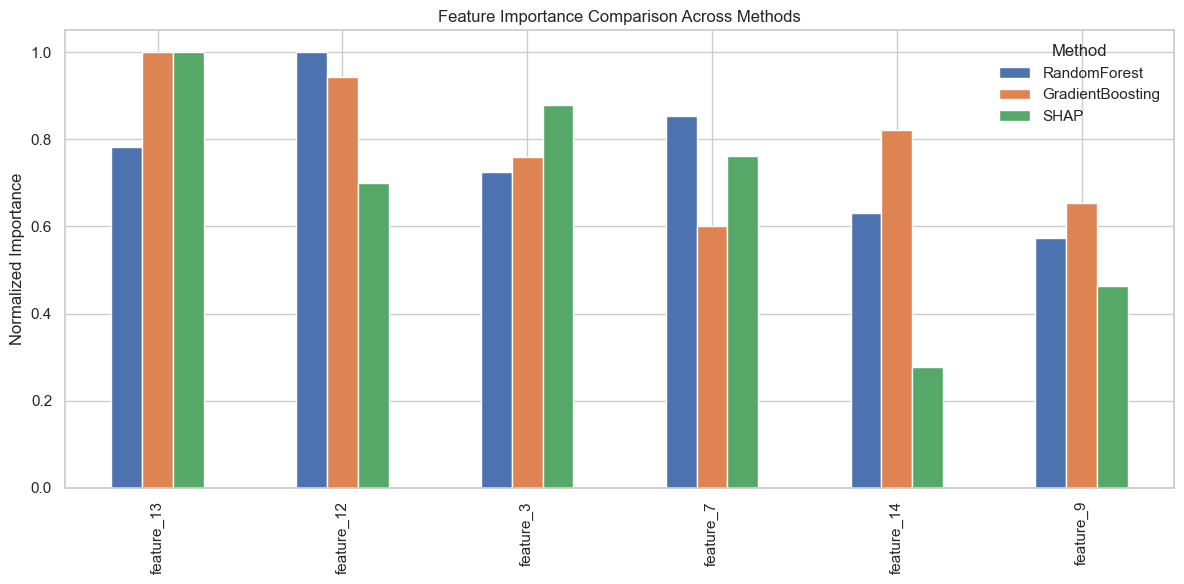

In [34]:
# Combine and compare different importance methods
comparison = pd.DataFrame(index=X_train.columns)

# Add normalized importance from different methods
comparison['RandomForest'] = rf_importances.set_index('Feature')['Importance']
comparison['GradientBoosting'] = gb_importances.set_index('Feature')['Importance']

# Add SHAP
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': np.abs(shap_values).mean(0)
})
comparison['SHAP'] = shap_importance.set_index('Feature')['Importance']

# Normalize each method (0-1 scale)
for col in comparison.columns:
    comparison[col] = comparison[col] / comparison[col].max()

# Calculate average importance across methods
comparison['Average'] = comparison.mean(axis=1)
comparison = comparison.sort_values('Average', ascending=False)

print("Feature Importance Across Different Methods (Normalized):")
print(comparison)

# Visualization
plt.figure(figsize=(12, 8))
comparison.iloc[:, :-1].plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance Comparison Across Methods')
plt.ylabel('Normalized Importance')
plt.legend(title='Method')
plt.tight_layout()

<a id='pipeline'></a>
## 11. Putting It All Together

In this section, we'll integrate all the feature engineering techniques we've learned into a cohesive pipeline. We'll demonstrate how to build an end-to-end workflow that handles different types of features and prepares them for machine learning models.

### Creating the Feature Engineering Pipeline

We'll build a pipeline that handles different feature types simultaneously:

In [35]:
# Let's assume we have a dataset with various feature types
# This would come from previous sections where we loaded the data
# For this example, we'll create a synthetic dataset

np.random.seed(42)
n_samples = 1000

# Create synthetic data
data = {
    # Numeric features
    'age': np.random.randint(18, 90, n_samples),
    'income': np.random.randint(20000, 200000, n_samples),
    'spending': np.random.randint(5000, 100000, n_samples),
    
    # Categorical features
    'education': np.random.choice(['High School', 'Bachelor', 'Master', 'PhD'], n_samples),
    'job_category': np.random.choice(['Tech', 'Finance', 'Healthcare', 'Education', 'Other'], n_samples),
    
    # Date feature (as string for now)
    'join_date': pd.date_range(start='2010-01-01', periods=n_samples).astype(str),

}

# Create DataFrame
df = pd.DataFrame(data)

# Add some missing values
for col in df.columns:
    mask = np.random.random(n_samples) < 0.05  # 5% missing values
    df.loc[mask, col] = np.nan

# Convert join_date to datetime
df['join_date'] = pd.to_datetime(df['join_date'])

# Create a target variable (classification example)
df['customer_segment'] = np.where(
    (df['age'] > 50) & (df['income'] > 100000), 'Premium',
    np.where((df['age'] < 30) & (df['spending'] > 50000), 'Young Spender', 'Regular')
)

In [36]:
# Display first few rows of our dataset
df.head()

,age,income,spending,education,job_category,join_date,customer_segment
0,69.0,129575.0,58363.0,Master,Education,2010-01-01,Premium
1,32.0,130904.0,5661.0,PhD,Healthcare,2010-01-02,Regular
2,89.0,50678.0,49843.0,Bachelor,Finance,2010-01-03,Regular
3,78.0,96218.0,65963.0,Master,NaN,2010-01-04,Regular
4,38.0,83230.0,47828.0,PhD,Education,2010-01-05,Regular


### Feature Engineering for Each Data Type

Now, let's create a comprehensive pipeline that handles all feature types:

In [37]:
# Extract date features
df['join_year'] = df['join_date'].dt.year
df['join_month'] = df['join_date'].dt.month
df['join_day'] = df['join_date'].dt.day
df['join_day_of_week'] = df['join_date'].dt.dayofweek
df['account_age_days'] = (pd.Timestamp('2023-01-01') - df['join_date']).dt.days

# Drop the original date column as we've extracted its features
df = df.drop('join_date', axis=1)

In [38]:
# Define feature types
numeric_features = ['age', 'income', 'spending', 'join_year', 'join_month', 'join_day', 
                    'join_day_of_week', 'account_age_days']
categorical_features = ['education', 'job_category']
text_features = ['feedback']

# Define X and y
X = df.drop('customer_segment', axis=1)
y = df['customer_segment']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
# Create transformers for each feature type
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine all transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the full pipeline with a classifier
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

### Training and Evaluating the Model with the Pipeline

In [40]:
# Train the model with the pipeline
full_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = full_pipeline.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9700

Classification Report:
               precision    recall  f1-score   support

      Premium       0.98      0.93      0.96        59
      Regular       0.96      0.99      0.98       128
Young Spender       1.00      0.92      0.96        13

     accuracy                           0.97       200
    macro avg       0.98      0.95      0.96       200
 weighted avg       0.97      0.97      0.97       200



### Analyzing Feature Importance

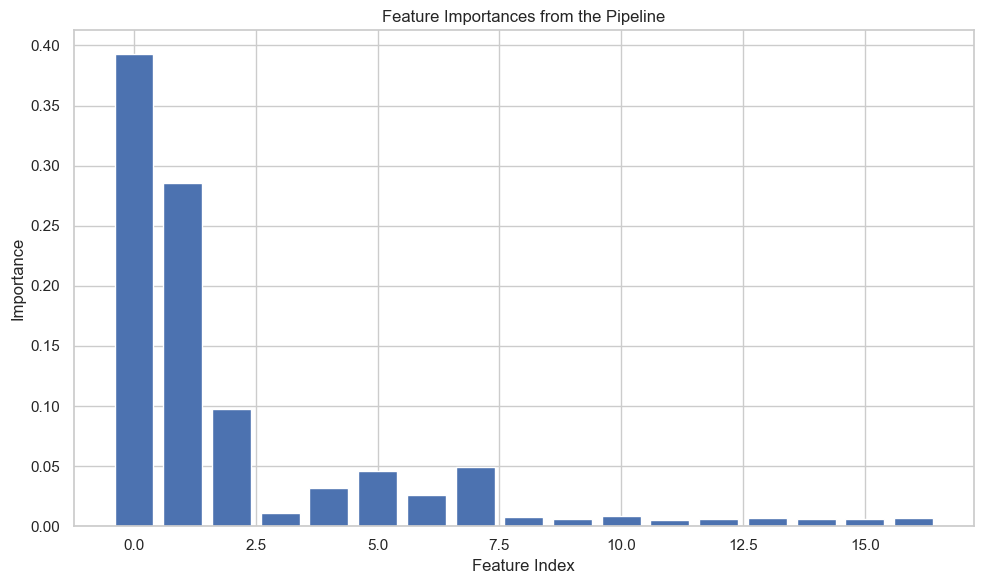

In [41]:
# Extract feature names after transformation
# This is complex because transformers create new feature names (especially one-hot encoding and TF-IDF)
# For simplicity, we'll just analyze the importance directly

# Get feature importances from the RandomForestClassifier
importances = full_pipeline.named_steps['classifier'].feature_importances_

# Display importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.title('Feature Importances from the Pipeline')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.tight_layout()

### Using the Pipeline for New Data

In [42]:
# Create sample new data
new_data = pd.DataFrame({
    'age': [35, 62, 28],
    'income': [60000, 150000, 45000],
    'spending': [30000, 70000, 60000],
    'education': ['Bachelor', 'Master', 'High School'],
    'job_category': ['Tech', 'Finance', 'Tech'],
    'join_year': [2018, 2015, 2021],
    'join_month': [3, 7, 12],
    'join_day': [15, 22, 5],
    'join_day_of_week': [2, 4, 0],
    'account_age_days': [1752, 2920, 730]
})

# Make predictions on new data
new_predictions = full_pipeline.predict(new_data)
new_data['predicted_segment'] = new_predictions

# Display results
new_data[['age', 'income', 'education', 'predicted_segment']]

,age,income,education,predicted_segment
0,35,60000,Bachelor,Regular
1,62,150000,Master,Premium
2,28,45000,High School,Young Spender


### Saving the Pipeline for Future Use

In [43]:
# Import joblib for saving the model
import joblib

# Save the entire pipeline
joblib.dump(full_pipeline, 'feature_engineering_pipeline.joblib')

# To load it later
# loaded_pipeline = joblib.load('feature_engineering_pipeline.joblib')

['feature_engineering_pipeline.joblib']

### Conclusion

Feature engineering is both an art and a science. While the techniques covered in this tutorial provide a strong foundation, the most effective features often come from domain knowledge and creative thinking. Keep experimenting with different approaches, and remember that feature engineering is often the key differentiator in building high-performing machine learning models.

Good luck on your feature engineering journey!

## HOMEWORK EXERCISE

TBD